# DATA 512: Part 1 - Common Analysis


In this assignment, I aim to analyze wildfire data and predict future smoke impact on my assigned city — Hartford, CT, using various computational and and forecasting techniques. This analysis involved obtaining and filtering the data from the USGS (United States Geological Survey), calculating distances using GIS systems, constructing a smoke impact estimate, retrieving air quality data via US EPA API, and developing an ARIMA model to forecast future impacts in the next 25 years. 

The course project will require that you analyze wildfire impacts on a specific city in the US. The end goal is to be able to inform policy makers, city managers, city councils, or other civic institutions, to make an informed plan for how they could or whether they should make plans to mitigate future impacts from wildfires.

In [2]:
#importing relevant libraries
import json, time
import requests
from pyproj import Transformer, Geod
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wildfire.Reader import Reader as WFReader
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

## Step 0: Data acquisition

The common analysis research question is based on one specific dataset: the 

**Data Source**

The analysis is based on the [Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons)](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81), which provides wildfire data from the 1800s to the present. The dataset is formatted as a GeoJSON file.

**File Path**

The data file is located at:GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json

To reproduce this wildfira data, please follow the steps below: 
1. Obtain the Dataset: Download the GeoJSON file from the official USGS Combined Wildland Fire Polygons dataset.
2. Set File Path: Save the dataset in the directory as specified in the variable DATA_PATH. Update the path in the code if necessary.
3. Install Required Libraries: Ensure Python libraries like json and geospatial libraries are installed.
4. Run the Load Function: Use the `load_geojson()` function to read the dataset into your analysis pipeline.

In the code that follows, I will be obtain the data from the USGS combine wildland fire polygons, using a load GeoJSON function. 

In [3]:
# Constants for the below code
DATA_PATH = "GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json" 
START_YEAR = 1961
END_YEAR = 2022
MAX_DISTANCE_MILES = 650  # in miles
CITY_LOCATIONS = {
    'hartford' :      {'city'   : 'Hartford',
                       'latlon' : [41.7637, -72.6851] }
}
SEASON_START_MONTH = 5  # May
SEASON_END_MONTH = 10  # October

In [4]:
# Function to load GeoJSON data
def load_geojson(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

These functions or obtained from Dr. David W. McDonald's example code: [Wildifre Proximity Computation Example Code](https://colab.research.google.com/drive/1B7AGlaW7d-27bHKLVXGBwLt8T-Elx-HB#scrollTo=8dloD_mnDHW3). This code was licensed for use as long as it is for the purposes of this DATA 512 UW MSDS assignment.

In [5]:
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average


## Step 1: Create fire smoke estimates

The common research question that I am answering is:
- What are the estimated wildfire smoke impacts on Hartford, CT each year for the most recent 60 years of wildfire data?

#### Key Functions Used
Ensure the following functions are implemented or defined in your script:
- `parse_and_calculate_distances`: Parses GeoJSON and calculates distances.
- `calculate_days_burning`: Determines the burning duration for each fire.
- `calculate_smoke_impact`: Computes the smoke impact based on fire size, burning duration, and distance.
- `refined_calculate_smoke_impact`: Adds normalization and non-linear weighting to the smoke impact calculation.

The resulting dataset is the `processed_wildfires` dataset includes processed wildfire data enriched with calculated attributes such as distances, burning durations, and smoke impact. This step prepares the data for further analysis.

The `processed_wildfires` dataset will adhere to the following conditions: 
- The estimate only considers the last 60 years of wildland fire data (1961-2021).
- The estimate only considers fires that are within 650 miles of Hartford.
- Defines the annual fire season as running from May 1st through October 31st.

Here's a guide to reproduce the filtered and processed wildfire dataset.

---
#### Step 1.1: Load and Filter the Wildfire Data
Start by loading the GeoJSON dataset using the `load_geojson` function. Apply the `parse_and_calculate_distances` function to extract attributes like fire size, discovery dates, and calculate distances from Hartford, CT. Filter the data to include fires from 1961-2022 during the wildfire season (May to October) and within 650 miles of Hartford. Finally, sort the filtered data by discovery date.

#### Step 1.2: Add Calculated Metrics
Use the `calculate_days_burning` function to compute the duration of each fire in days. Then, calculate an initial smoke impact metric using `calculate_smoke_impact`, which incorporates fire size, burning duration, and distance. Refine this metric with `refined_calculate_smoke_impact`, adding non-linear distance weighting (inverse-square law) and normalization.


#### Step 1.3: Export and Verify Data
Save the processed dataset as a CSV file. Perform quality checks to ensure key columns are complete and values are within expected ranges. Document assumptions (e.g., default end dates) and confirm the dataset includes all necessary fields for downstream analysis.



### Step 1.1 Obtain the data

The first step is to obtain the data. Below you will find more information about each steps and the code to reproduce the guide above. 

In [6]:
place = CITY_LOCATIONS["hartford"]

def parse_and_calculate_distances(data, city_coordinates, start_year, end_year, season_start, season_end):
    results = []

    for feature in tqdm(data['features'], desc="Processing Wildfire Data"):
        attributes = feature.get('attributes', {})
        geometry = feature.get('geometry', {})
        fire_year = int(attributes.get("Fire_Year", 0))
        fire_name = attributes.get("Listed_Fire_Names", "").split(",")[0]
        fire_size = attributes.get("GIS_Acres", 0)
        fire_type = attributes.get("Assigned_Fire_Type", "Unknown")
        
        # Filter by year
        if not (start_year <= fire_year <= end_year):
            continue

        # Extract and parse discovery date
        listed_dates = attributes.get("Listed_Fire_Dates")
        discovery_date = None

        if listed_dates:
            for date_str in listed_dates.split("|"):
                if "Discovery Date" in date_str:
                    try:
                        discovery_date = datetime.strptime(date_str.split(":")[-1].strip().split(" ")[0], '%Y-%m-%d')
                        break
                    except (ValueError, IndexError):
                        continue

        # Skip if no valid discovery date or not in season
        if not discovery_date or not (season_start <= discovery_date.month <= season_end):
            continue

        # Determine the correct ring data for distance calculation
        if "rings" in geometry:
            ring_data = geometry["rings"][0]
        elif "curveRings" in geometry:
            ring_data = geometry["curveRings"][0]
        else:
            raise Exception("No compatible geometry in this fire data!")

        # Calculate shortest and average distances
        average_distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)

        # Append results
        results.append({
            "year": fire_year,
            "discovery_date": discovery_date,
            "fire_name": fire_name,
            "fire_size_acres": fire_size,
            "fire_type": fire_type,
            "average_distance_miles": average_distance, 
            "listed_dates": listed_dates
        })

    return pd.DataFrame(results)

In [7]:
# Load the dataset
wildfire_data = load_geojson(DATA_PATH)

# Apply the function to calculate distances and additional attributes for each fire
city_coordinates = {"latitude": 41.7637, "longitude": -72.6851} 

processed_wildfires = parse_and_calculate_distances(
    wildfire_data,
    city_coordinates,
    START_YEAR,
    END_YEAR,
    SEASON_START_MONTH,
    SEASON_END_MONTH
)

Processing Wildfire Data:   0%|          | 0/135061 [00:00<?, ?it/s]

The dataset below: **`process_wildfires`**, contains all of the wildfires that have occurred, and the average distances of these fires to Hartford, CT. I've included the following columns: 
   - `year`: the year of the wildfire
   - `discovery_date`: the date the wildfire was noted
   - `fire_name`: the name of the wildfire
   - `fire_size_acres`: the acrege burned by the wildfire
   - `fire_type`: what type of fire it was (only wildfire in this case)
   - `average_distance_miles`: the average distance to Hartford, CT this wildfire is
   - `listed_dates`: a list of dates associated with the wildfire, including the discovery date, start date, and end date

In [7]:
processed_wildfires

,year,discovery_date,fire_name,fire_size_acres,fire_type,average_distance_miles,listed_dates
0,1961,1961-09-08,BIG ANTELOPE (5),55249.740141,Wildfire,2543.431680,Listed Wildfire Discovery Date(s): 1961-09-08 ...
1,1961,1961-07-10,HARLOW (5),43920.841077,Wildfire,2499.179844,Listed Wildfire Discovery Date(s): 1961-07-10 ...
2,1961,1961-09-02,RANCHERIA (5),34233.698603,Wildfire,2525.772115,Listed Wildfire Discovery Date(s): 1961-09-02 ...
3,1961,1961-07-12,BOLLINGER RIDGE (5),32866.053451,Wildfire,2590.935436,Listed Wildfire Discovery Date(s): 1961-07-12 ...
4,1961,1961-09-01,Ditch Creek (3),27269.045936,Wildfire,2326.691130,Listed Wildfire Discovery Date(s): 1961-09-01 ...
...,...,...,...,...,...,...,...
43070,2020,2020-07-26,Point (4),0.006473,Wildfire,2452.098700,Listed Wildfire Discovery Date(s): 2020-07-26 ...
43071,2020,2020-07-23,Bald (4),0.000444,Wildfire,2182.874381,Listed Wildfire Discovery Date(s): 2020-07-23 ...
43072,2010,2010-06-29,Holiday Fire (2),1545.863939,Wildfire,534.734687,Listed Wildfire Discovery Date(s): 2010-06-29 ...
43073,2019,2019-07-09,Bear (1),9251.423415,Wildfire,2005.588426,Listed Wildfire Discovery Date(s): 2019-07-09 ...


### Step 1.2 Filter the data

I now create a smaller version of this dataset by filtering it to the wildfires that have occrued within 650 miles of Hartford , CT.

In [25]:
selected_processed_wildfires = processed_wildfires[processed_wildfires.average_distance_miles <= 650]
selected_processed_wildfires = selected_processed_wildfires.sort_values(by="discovery_date").reset_index(drop=True)

The function `get_end_date` searches for the end date in the listed_fires column of my earlier dataset to find the end date for the specifiec wildfire. If no end date is given, I assume that the fire lasted until the end of the fire season (October 31st). 

Next, the `calculate_days_burning` function `selected_processed_wildfires` dataset, giving each wildifre in a dataset the total number of days it burned.

In [9]:
import re
from datetime import datetime

# Function to extract the end date or use default end of fire season (October 31st)
def get_end_date(listed_dates, fire_year):
    # Default end date as October 31st of the fire year
    end_date = datetime(fire_year, 10, 31)

    # Look for a "Prescribed Fire End Date(s)" in listed_dates
    if listed_dates:
        match = re.search(r"Prescribed Fire End Date\(s\): (\d{4}-\d{2}-\d{2})", listed_dates)
        if match:
            try:
                # Parse the found end date
                end_date = datetime.strptime(match.group(1), '%Y-%m-%d')
            except ValueError:
                pass  # Keep default if parsing fails

    return end_date

# Calculate days_burning and add it as a new column
def calculate_days_burning(df):
    df['days_burning'] = df.apply(
        lambda row: (get_end_date(row['listed_dates'], row['year']) - row['discovery_date']).days
        if pd.notnull(row['discovery_date']) else None,
        axis=1
    )
    return df

# Apply the function to calculate days_burning
selected_processed_wildfires = calculate_days_burning(processed_wildfires)

In [54]:
selected_processed_wildfires[selected_processed_wildfires['days_burning'] <= 0 ] = 1 

### Step 1.3 Calculate Smoke Impact Estimate


The fomula I chose for my smoke impact is calculated by this formula: 
```markdown
Smoke Impact = (Fire Size (acres) × Days Burning) / (Distance (miles)^2)
```

To understand the **intuition behind my formula** please read below:

1. **Fire Size (acres)**: Larger fires generate more smoke, so the fire size is directly proportional to the smoke impact. A larger fire implies a higher potential to affect air quality.

2. **Days Burning**: Fires that last longer release smoke over extended periods. Including the burning duration accounts for the sustained effect of smoke in the atmosphere.

3. **Distance (miles)^2**: Smoke impact decreases as the distance from the fire increases due to atmospheric dispersion. Using the square of the distance reflects the rapid reduction in smoke concentration over longer distances, consistent with physical dispersion models.

4. **Combined Effect**: The numerator `(Fire Size × Days Burning)` represents the total smoke potential, while the denominator `(Distance^2)` adjusts for the spatial dispersion of smoke, providing a realistic estimate of impact.

In the cells below I calculate the individual smoke estimates for each fire using the `calculate_smoke_impact()` function. 

To aggregate this by year, I also calculate the cumulative annual smoke estimate to by summing up each wildfire's smoke estime in the year. This column is named: `cumulative_smoke_impact`.


In [56]:
# Calculate individual smoke estimates for each fire
def calculate_smoke_impact(df):
    df["smoke_impact"] = df.apply(
        lambda row: (row["fire_size_acres"] * row["days_burning"]) / (row["average_distance_miles"])
        if row["average_distance_miles"] > 0 else np.nan,  # Avoid division by zero
        axis=1
    )
    return df

# Apply the smoke impact calculation
selected_processed_wildfires = calculate_smoke_impact(selected_processed_wildfires)

# Calculate cumulative annual smoke impact
selected_processed_wildfires["cumulative_smoke_impact"] = selected_processed_wildfires.groupby("year")["smoke_impact"].cumsum()

# Display the updated DataFrame to verify the new columns
selected_processed_wildfires

,year,discovery_date,fire_name,fire_size_acres,fire_type,average_distance_miles,listed_dates,days_burning,smoke_impact,cumulative_smoke_impact
0,1963,1963-07-04 00:00:00,COLORED (3),30.743401,Wildfire,329.436683,Listed Wildfire Discovery Date(s): 1963-07-04 ...,119,11.105213,11.105213
1,1965,1965-07-24 00:00:00,SKYLAND (2),1.989099,Wildfire,371.768926,Listed Wildfire Discovery Date(s): 1965-07-24 ...,99,0.529686,0.529686
2,1965,1965-07-31 00:00:00,SANDY BOTT (2),1.989492,Wildfire,390.728688,Listed Wildfire Discovery Date(s): 1965-07-31 ...,92,0.468441,0.998127
3,1965,1965-08-17 00:00:00,LEWIS PEAK (2),0.248821,Wildfire,400.599643,Listed Wildfire Discovery Date(s): 1965-08-17 ...,75,0.046584,1.044711
4,1965,1965-09-07 00:00:00,PUMPKIN HI (2),0.099449,Wildfire,368.947433,Listed Wildfire Discovery Date(s): 1965-09-07 ...,54,0.014556,1.059266
...,...,...,...,...,...,...,...,...,...,...
819,2019,2019-07-25 00:00:00,Aulerich (2),14.932147,Wildfire,570.423895,Listed Wildfire Discovery Date(s): 2019-07-25 ...,98,2.565374,27.884029
820,2019,2019-09-20 00:00:00,Amos Ridge (2),9.824548,Wildfire,640.400161,Listed Wildfire Discovery Date(s): 2019-09-20 ...,41,0.628992,28.513021
821,2019,2019-09-29 00:00:00,Sky Bridge (4),317.507929,Wildfire,640.235005,Listed Wildfire Discovery Date(s): 2019-09-29 ...,32,15.869569,44.382590
822,2019,2019-10-16 00:00:00,Snake Rock (2),23.898114,Wildfire,479.018000,Listed Wildfire Discovery Date(s): 2019-10-16 ...,15,0.748347,45.130937


In [339]:
# Convert to CSV for upload
selected_processed_wildfires.to_csv('selected_processed_wildfires.csv', index=False)

### Step 1.4 Compare estimates to US EPA AQI (Air Quality Index)

With the wildfire data, processed, filtered for our specific city, and smoke impact estimates calculated, it's time to obtain data about the Air Quality Index for each of the dates of the wildfire. 

In this step I use Dr.McDonald's [US EPA Air Quality System API Sample Code](https://colab.research.google.com/drive/1fwS60QStiMDqwINvW2LEDFBX5xg6Wnmg#scrollTo=y89K1OKsr1fz) to requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions.

The code and functions below (until specified are directly from the example code. This code was licensed for reuse, as long as it is used for the UW MSDS DATA 512 Curriculum.

To reproduce this data, please run the following cells, and replace these variables with your information and chosen AQI parameters: 
- USERNAME
- AQI_PARAMS_GASEOUS
- AQI_PARAMS_PARTICULATES
- CITY_LOCATIONS
- AQI_PARAM_CLASS
- EXTRACTION_FIELDS

By updating variables, you can ensure that you are obtaining AQI data that is suitable for your needs. For further information please refer to Dr.McDonald's [US EPA Air Quality System API Sample Code](https://colab.research.google.com/drive/1fwS60QStiMDqwINvW2LEDFBX5xg6Wnmg#scrollTo=y89K1OKsr1fz).

In [11]:
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'

#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'

#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

In [12]:
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [16]:
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
print("Requesting SIGNUP ...")
USERNAME = "trishaprasant@gmail.com"
response = request_signup(USERNAME)
print(json.dumps(response,indent=4))

Requesting SIGNUP ...
HTTPSConnectionPool(host='aqs.epa.gov', port=443): Max retries exceeded with url: /data/api/signup?email=trishaprasant@gmail.com (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x38478f350>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
null


In [13]:
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [ ]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#   Structure a request to get the sensor IDs associated with the AQI
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

In [100]:
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

CITY_LOCATIONS = {
    'hartford' :       {'city'   : 'Hartford',
                       'county' : 'Hartford',
                       'state'  : 'Connecticut',
                       'fips'   : '09003',
                       'latlon' : [41.7637, -72.6851] }
}

In [ ]:
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['hartford']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['hartford']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

In [130]:
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date.  

#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result

We are now able to see the provided API data., alonw with the various monitors around the Hartford, CT area.

In [182]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['hartford']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['hartford']['fips'][2:]

gaseous_aqi = request_daily_summary(request_template=request_data, begin_date="20210501", end_date="20210731")
extract_gaseous = extract_summary_from_response(gaseous_aqi)
print("Summary of gaseous extraction ...")
print(json.dumps(extract_gaseous,indent=4))

particulate_aqi = request_daily_summary(request_template=request_data, begin_date="20210501", end_date="20210731")
extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
print(json.dumps(extract_particulate,indent=4))

Summary of gaseous extraction ...
{
    "1003": {
        "local_site_name": "McAuliffe Park",
        "site_address": "Remington Road (see coordinates)",
        "state": "Connecticut",
        "county": "Hartford",
        "city": "East Hartford",
        "pollutant_type": {
            "44201": {
                "parameter_name": "Ozone",
                "units_of_measure": "Parts per million",
                "method": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
                "data": {
                    "20210501": [
                        {
                            "sample_duration": "1 HOUR",
                            "observation_count": 23,
                            "arithmetic_mean": 0.030174,
                            "aqi": null
                        },
                        {
                            "sample_duration": "8-HR RUN AVG BEGIN HOUR",
                            "observation_count": 24,
                            "arithmetic_mean": 0.029583,
 

Summary of particulate extraction ...
{
    "1003": {
        "local_site_name": "McAuliffe Park",
        "site_address": "Remington Road (see coordinates)",
        "state": "Connecticut",
        "county": "Hartford",
        "city": "East Hartford",
        "pollutant_type": {
            "44201": {
                "parameter_name": "Ozone",
                "units_of_measure": "Parts per million",
                "method": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
                "data": {
                    "20210501": [
                        {
                            "sample_duration": "1 HOUR",
                            "observation_count": 23,
                            "arithmetic_mean": 0.030174,
                            "aqi": null
                        },
                        {
                            "sample_duration": "8-HR RUN AVG BEGIN HOUR",
                            "observation_count": 24,
                            "arithmetic_mean": 0.02958

### Step 1.5: Combine API data with wildfire data

In the following code, I will be combining the API data from 1961 (or when the first available data point is), with my original filtered data from the USGS website.  

The functions I create here are: 
- `request_aqi_over_multiple_years` fetches AQI data by splitting multi-year requests.
- `process_aqi_data` computes the maximum AQI per day across parameters.

To reproduce these results, please run the above functions, the cells that follow, and update these parameters with your information: 

- email
- key 
- fips
- start_date
- end_date

The output of this step will result in a `aqi_df` dataset with all of the AQI indices for every date between the requested start and end dates, and the combined dataset (with both wildifre, smoke estimates, can be found in the `selected_processed_wildfires` dataset. 

In [185]:
# Function to split a multi-year request into multiple single-year requests
def request_aqi_over_multiple_years(email, key, param, start_date, end_date, fips):
    all_data = []
    
    # Loop over each year in the specified date range
    start_year = int(start_date[:4])
    end_year = int(end_date[:4])
    
    for year in range(start_year, end_year + 1):
        begin = f"{year}0101" if year != start_year else start_date
        end = f"{year}1231" if year != end_year else end_date

        # Fetch data for each year
        response = request_daily_summary(
            email_address=email, key=key, param=param,
            begin_date=begin, end_date=end, fips=fips
        )
        
        # Handle successful response
        if response and "Data" in response:
            all_data.extend(response["Data"])
    
    return all_data

# Usage example:
# Replace these variables with your actual email, API key, parameters, and FIPS code.
email = "trishaprasant@gmail.com"
key = "########"
fips = "09003"  # FIPS code for Hartford County, CT
start_date = "19610501"
end_date = "20211131"

gaseous_aqi_data = request_aqi_over_multiple_years(email, key, AQI_PARAMS_GASEOUS, start_date, end_date, fips)
particulate_aqi_data = request_aqi_over_multiple_years(email, key, AQI_PARAMS_PARTICULATES, start_date, end_date, fips)

In [ ]:
# Function to extract and calculate daily max AQI from response data
def process_aqi_data(aqi_data):
    daily_max_aqi = {}

    for record in aqi_data:
        date = record['date_local'].replace("-", "")
        param = record['parameter_code']
        aqi = record.get("aqi")
        
        if aqi is not None:
            if date not in daily_max_aqi:
                daily_max_aqi[date] = {}
            if param not in daily_max_aqi[date]:
                daily_max_aqi[date][param] = []
            daily_max_aqi[date][param].append(aqi)

    # Calculate daily max AQI per parameter
    daily_aqi_max = {}
    for date, params in daily_max_aqi.items():
        daily_max_for_date = max(
            [max(values) for values in params.values() if values], default=None
        )
        daily_aqi_max[date] = daily_max_for_date

    return daily_aqi_max

# Process both gaseous and particulate data
gaseous_daily_max_aqi = process_aqi_data(gaseous_aqi_data)
particulate_daily_max_aqi = process_aqi_data(particulate_aqi_data)

# Combine into a single dictionary for all dates
combined_aqi_max = {**gaseous_daily_max_aqi, **particulate_daily_max_aqi}

# Convert the combined AQI max data into a DataFrame for merging
aqi_df = pd.DataFrame(list(combined_aqi_max.items()), columns=["date", "daily_max_aqi"])
aqi_df["date"] = pd.to_datetime(aqi_df["date"], format="%Y%m%d")

In [338]:
# Convert to CSV file to upload
aqi_df.to_csv('aqi_data.csv', index=False)

In [58]:
# Using new variable to allow for mistakes, and not rewrite original datasets
example2 = selected_processed_wildfires

In [60]:
# Add AQI to processed_wildfires DataFrame by merging on discovery date
example2["discovery_date"] = pd.to_datetime(example2["discovery_date"])

From the final/combined dataset `example2` we can see that when my cumulative smoke impact estimate (`cumulative_smoke_impact`) is compared with their corresponding average AQI (`daily_max_aqi`), the two variables are not similar. In fact the AQI estimate is much smaller at times than the cumulative smoke estimate. This might mean that there is a disconnect in how the AQI is calculated, versus how my smoke estimate is calculated. 

More specifically, the AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...). The average AQI estimate in my dataset looks at Gaseous AQI pollutants like: CO, SO2, NO2, and O2 and 
Particulate AQI pollutants like PM10, PM2.5, and Acceptable PM2.5. These might be correlated to the number of days the wildfire burned, how far away it was from the city, and the size of the fire, but way in which I calculated my estimate might not be the most accurate in terms of comapring it to the AQI data. Therefore, it makes sense that these two values are significantly different.


In [61]:
example2 = example2.sort_values(by="discovery_date").reset_index(drop=True)
example2

,year,discovery_date,fire_name,fire_size_acres,fire_type,average_distance_miles,listed_dates,days_burning,smoke_impact,cumulative_smoke_impact
0,1963,1963-07-04,COLORED (3),30.743401,Wildfire,329.436683,Listed Wildfire Discovery Date(s): 1963-07-04 ...,119,11.105213,11.105213
1,1965,1965-07-24,SKYLAND (2),1.989099,Wildfire,371.768926,Listed Wildfire Discovery Date(s): 1965-07-24 ...,99,0.529686,0.529686
2,1965,1965-07-31,SANDY BOTT (2),1.989492,Wildfire,390.728688,Listed Wildfire Discovery Date(s): 1965-07-31 ...,92,0.468441,0.998127
3,1965,1965-08-17,LEWIS PEAK (2),0.248821,Wildfire,400.599643,Listed Wildfire Discovery Date(s): 1965-08-17 ...,75,0.046584,1.044711
4,1965,1965-09-07,PUMPKIN HI (2),0.099449,Wildfire,368.947433,Listed Wildfire Discovery Date(s): 1965-09-07 ...,54,0.014556,1.059266
...,...,...,...,...,...,...,...,...,...,...
819,2019,2019-07-25,Aulerich (2),14.932147,Wildfire,570.423895,Listed Wildfire Discovery Date(s): 2019-07-25 ...,98,2.565374,27.884029
820,2019,2019-09-20,Amos Ridge (2),9.824548,Wildfire,640.400161,Listed Wildfire Discovery Date(s): 2019-09-20 ...,41,0.628992,28.513021
821,2019,2019-09-29,Sky Bridge (4),317.507929,Wildfire,640.235005,Listed Wildfire Discovery Date(s): 2019-09-29 ...,32,15.869569,44.382590
822,2019,2019-10-16,Snake Rock (2),23.898114,Wildfire,479.018000,Listed Wildfire Discovery Date(s): 2019-10-16 ...,15,0.748347,45.130937


### Step 1.6 Develop a predictive model

The model I create in the steps below predict smoke estimates for every year for the next 25 years (i.e., 2025-2050). I will also make sure that these predictions convey appropriate levels of uncertainty in the prediction. 

In this model, I chose to use the ARIMA model (Auto-Regressive Integrated Moving Average) for predicting future smoke estimates. I followed these steps:

1. First, I summed cumulative_smoke_estimate for each year.
2. Next, I check for stationarity using the Augmented Dickey-Fuller test
3. Differencing if the series is not stationary
2. Then, I trained the SARIMAX model on data up to a recent year and reserve a few years for testing.
3. Determine SARIMAX Parameters: Use an auto-ARIMA approach to identify the best parameters (p, d, q) for the model.
4. Forecast for 25 Years (2025-2050): Use the trained ARIMA model to predict smoke estimates for each year, along with confidence intervals for uncertainty.


In [ ]:
# Selecting wildifre date and cumulative smoke impact columns, as these are the only ones needed for forecasting.
selected_data = example2[['discovery_date', 'cumulative_smoke_impact']]

/var/folders/kp/42tvxzv924xdtdyzydmjjp380000gn/T/ipykernel_74463/1994540708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['discovery_date'] = pd.to_datetime(data['discovery_date'])


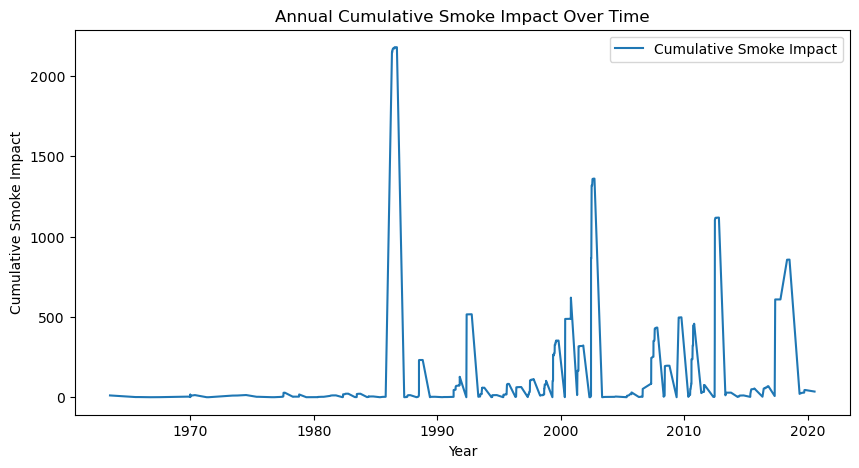

In [66]:
data = selected_data 
data['discovery_date'] = pd.to_datetime(data['discovery_date'])
data.set_index('discovery_date', inplace=True)
#data_resampled = data['cumulative_smoke_impact'].resample('Y').sum()

plt.figure(figsize=(10, 5))
plt.plot(data, label='Cumulative Smoke Impact')
plt.title('Annual Cumulative Smoke Impact Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Smoke Impact')
plt.legend()
plt.show()

**What does this graph mean?** This graph shows the annual cumulative smoke impact in Hartford, CT, from the 1960s to the 2020s. For most of the early years, the impact remains low, with occasional spikes, particularly in the late 1980s and early 1990s, indicating years with severe wildfire activity or closer fires. Starting in the late 1990s, there’s a noticeable upward trend, reflecting the increasing frequency and intensity of wildfires affecting the region. These fluctuations highlight the variability of wildfire smoke exposure and the growing importance of addressing its long-term impacts on Hartford.

ADF Test Statistic: -6.443763381592611
p-value: 1.5844168806982427e-08


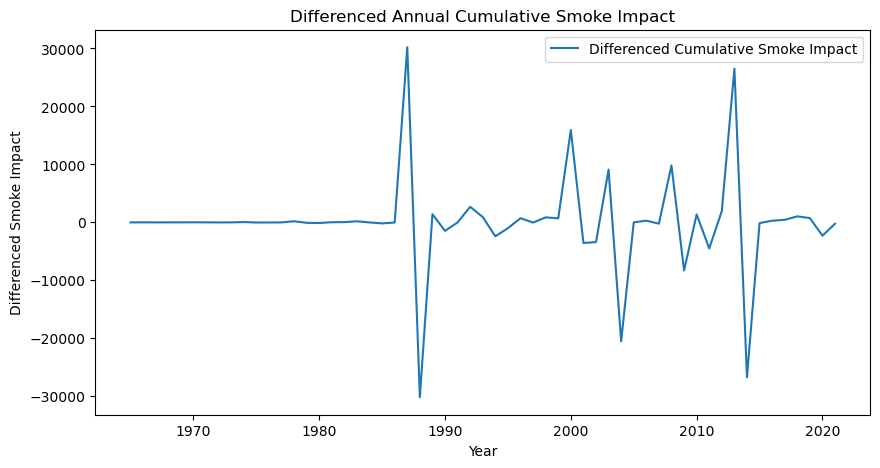

Differenced ADF Test Statistic: -6.1782903815190595
Differenced p-value: 6.548778725993752e-08


In [307]:
# Check for stationarity using the Augmented Dickey-Fuller test
adf_test = adfuller(data_resampled)
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Differencing if the series is not stationary
data_diff = data_resampled.diff().dropna()

plt.figure(figsize=(10, 5))
plt.plot(data_diff, label='Differenced Cumulative Smoke Impact')
plt.title('Differenced Annual Cumulative Smoke Impact')
plt.xlabel('Year')
plt.ylabel('Differenced Smoke Impact')
plt.legend()
plt.show()

adf_test_diff = adfuller(data_diff)
print("Differenced ADF Test Statistic:", adf_test_diff[0])
print("Differenced p-value:", adf_test_diff[1])

**What do these results mean?** To analyze the annual cumulative smoke impact data, I used the Augmented Dickey-Fuller (ADF) test to check for stationarity, a key requirement for time series modeling. The initial ADF test showed a test statistic of -6.44 and a p-value of 1.58e-08, indicating that the original series was stationary. 

I then applied differencing to highlight year-over-year changes in smoke impact, emphasizing its variability. The differenced series was also tested for stationarity, with an ADF test statistic of -6.18 and a p-value of 6.55e-08, confirming stationarity. The differenced data revealed periods of stability and significant fluctuations, reflecting abrupt increases or decreases in wildfire smoke impacts. These results underscore the unpredictable nature of wildfire smoke, and how it might rely on seasonality. This encouraged me to apply a seasonal time series model like SARIMAX to forecast future trends.

In [67]:
# Split the data into train and test sets
train = data[:-5]
test = data[-5:]

# SARIMA model with adjusted seasonal order
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
sarima_model = model.fit(disp=False)

forecast = sarima_model.forecast(steps=len(test))

/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/trishaprasant/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

Root Mean Squared Error: 3592.359593908614


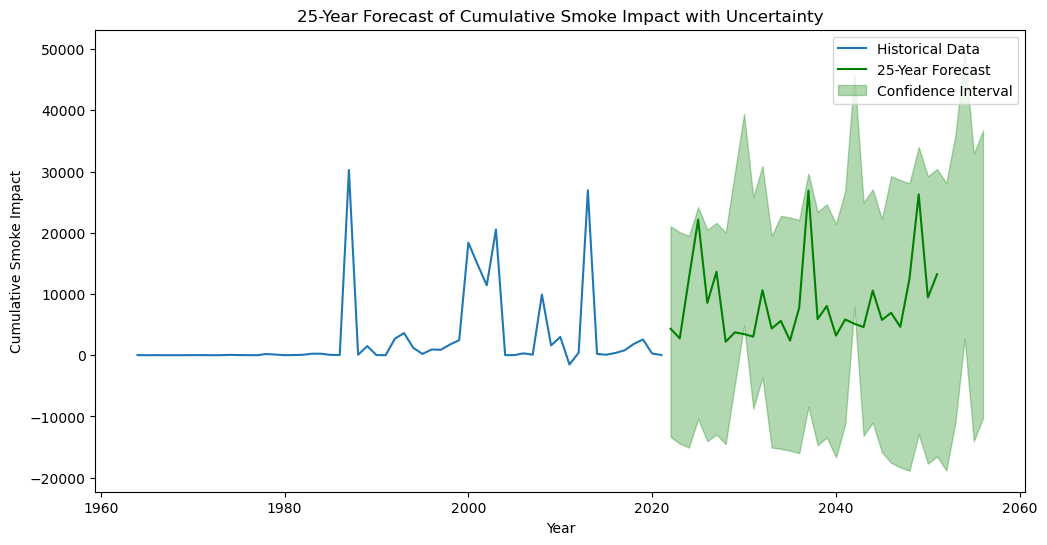

In [319]:
rmse = sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error: {rmse}")

# Extend the forecast to the next 25 years with confidence intervals
future_forecast = sarima_model.get_forecast(steps=35)
future_forecast_mean = future_forecast.predicted_mean
future_forecast_conf_int = future_forecast.conf_int()

future_index = pd.date_range(start=data_resampled.index[-1] + pd.DateOffset(years=1), periods=35, freq='Y')
future_forecast_series = pd.Series(future_forecast_mean, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(data_resampled, label='Historical Data')
plt.plot(future_forecast_series, label='25-Year Forecast', color='green')

#confidence intervals
plt.fill_between(
    future_index,
    future_forecast_conf_int.iloc[:, 0],
    future_forecast_conf_int.iloc[:, 1],
    color='green',
    alpha=0.3,
    label='Confidence Interval'
)

plt.title('25-Year Forecast of Cumulative Smoke Impact with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Cumulative Smoke Impact')
plt.legend()
plt.show()

**What does this graph mean?** This graph illustrates the 25-Year Forecast of Cumulative Smoke Impact for Hartford, CT, including uncertainty intervals. The historical data (blue line) shows the cumulative smoke impact up to the present, while the forecast (green line) projects future trends based on the SARIMAX model.

The forecast suggests variability in smoke impacts over the next 25 years, with significant year-to-year fluctuations. The shaded green confidence interval captures the uncertainty in these predictions, widening over time as the forecast extends further into the future.

## Step 2: Visualize aspects of your analysis

In this step, I will illustrate the work of my analysis with a few time series graphs. The wildfire data is annual, so your time series will be on an annual basis. All the time series cover the analysis range (1961 - 2021) but not the 25 year prediction range.

**1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.**

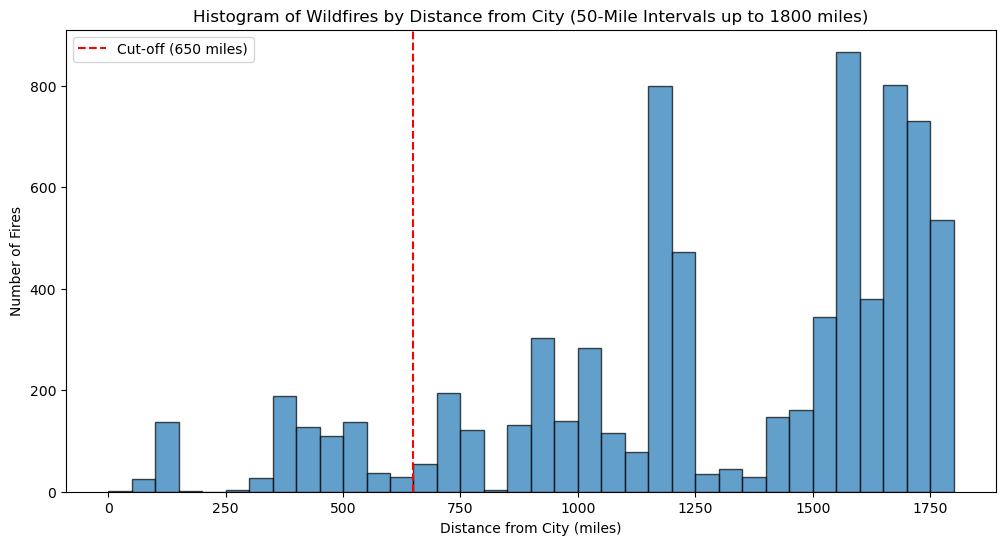

In [322]:
import matplotlib.pyplot as plt

# Filter 1800 miles 
within_1800_miles = processed_wildfires[processed_wildfires['average_distance_miles'] <= 1800]

bins = range(0, 1801, 50)

plt.figure(figsize=(12, 6))
plt.hist(within_1800_miles['average_distance_miles'], bins=bins, edgecolor='black', alpha=0.7)
plt.axvline(x=650, color='red', linestyle='--', label='Cut-off (650 miles)')
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Histogram of Wildfires by Distance from City (50-Mile Intervals up to 1800 miles)')
plt.legend()
plt.show()

**Visualization 1 Writeup**

This histogram displays the distribution of wildfire events based on their distance from the assigned city. The x-axis represents distance intervals in miles, divided into 50-mile bins, going up to 1800 miles. The y-axis shows the number of wildfires that occurred within each distance bin. A vertical red dashed line at 650 miles marks the distance cut-off used in the model for wildfire impact analysis, indicating that only wildfires within this range were considered for the model.
The histogram provides insights to the audience into how wildfire frequency varies with distance. Most wildfires appear to be concentrated in specific distance bands, most occurring beyond the 650-mile cutoff. This could suggest a geographic concentration of wildfire-prone areas (forests) at further distances from the city.

*Data Processing:*
The data for this visualization was filtered to include wildfires up to 1800 miles from the assigned city. The histogram was then generated by binning the distances into 50-mile intervals and counting the occurrences within each bin. This visualization provides a clear understanding of the distribution of wildfires by proximity to the city, highlighting the cutoff distance used for modeling.


**2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.**

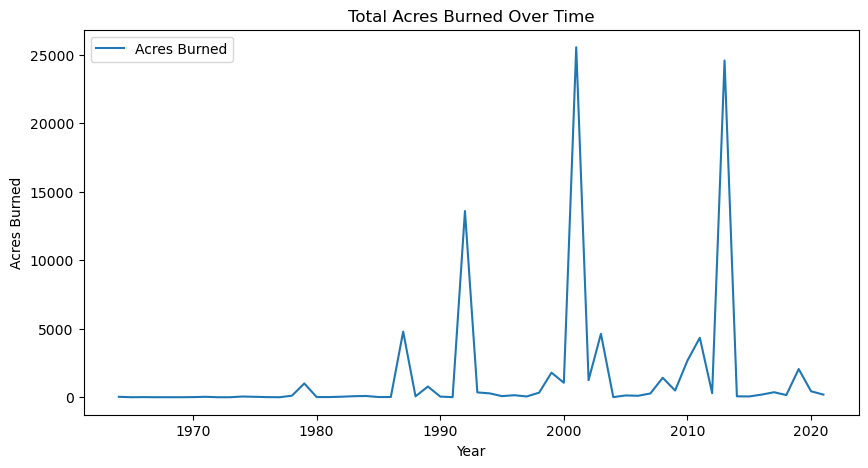

In [323]:
data = selected_processed_wildfires
data['discovery_date'] = pd.to_datetime(data['discovery_date'])
data.set_index('discovery_date', inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(data, label='Acres Burned')
plt.title('Total Acres Burned Over Time')
plt.xlabel('Year')
plt.ylabel('Acres Burned')
plt.legend()
plt.show()

**Visualization 2 Writeup**

This line plot shows the annual total acres burned by wildfires that occurred within 650 miles of the assigned city. The x-axis represents the years spanning the timeframe of the dataset. The y-axis shows the total acres burned each year. The line indicates the fluctuations in burned acreage over time, with sharp peaks indicating specific years with unusually high wildfire activity.
The visualization allows the viewer to identify trends or patterns in annual burned acreage over the years. Some notable spikes in specific years include 1993, 2002, and 2014, when large wildfire events occurred. The steady periods between peaks suggest years with relatively lower fire activity.

*Data Processing:*
The data was filtered to include only wildfires within 650 miles of the city. The burned acreage for each fire was summed by year to obtain annual totals. This aggregation enables my audience to compare total burned areas year by year, emphasizing high-activity years and long-term trends in wildfire impact within the 650 miles from Hartford, CT.


**3. Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.**

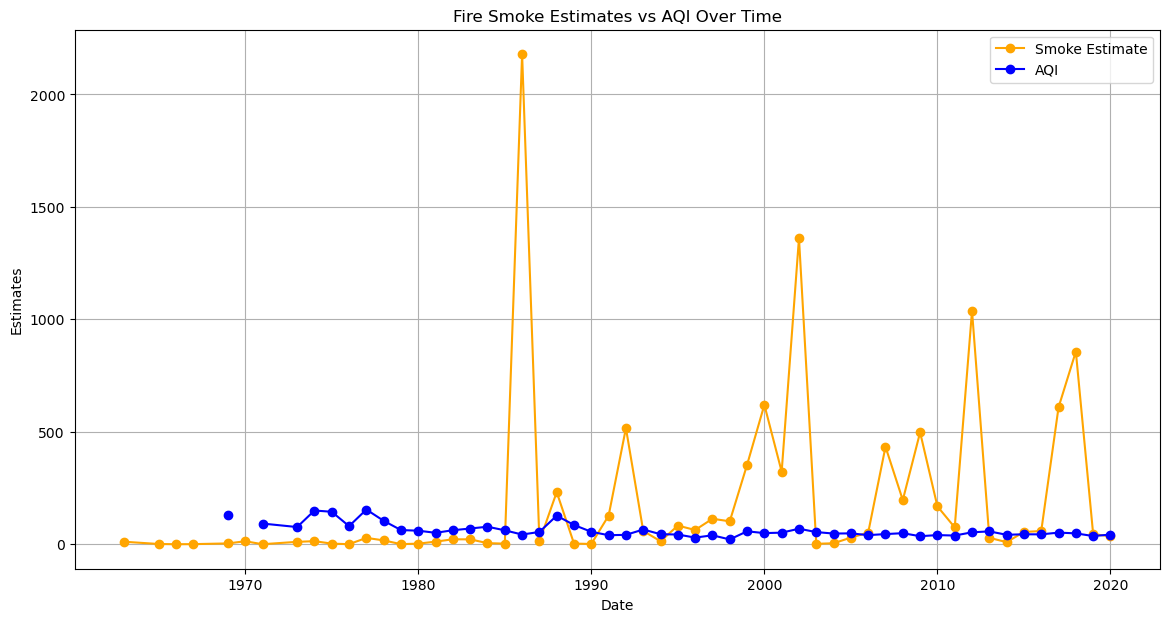

In [334]:
import matplotlib.pyplot as plt

example2['discovery_date'] = pd.to_datetime(example2['discovery_date'])

# grouping by year and aggregating smoke estimates and max AQI values
daily_data = example2.groupby('year').agg({
    'smoke_impact': 'sum',
    'daily_max_aqi': 'mean'
})

plt.figure(figsize=(14, 7))
plt.plot(daily_data.index, daily_data['smoke_impact'], label='Smoke Estimate', color='orange', marker='o', linestyle='-')
plt.plot(daily_data.index, daily_data['daily_max_aqi'], label='AQI', color='blue', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Estimates')
plt.title('Fire Smoke Estimates vs AQI Over Time')
plt.legend()
plt.grid(True)
plt.show()

**Visualization 3 Writeup**

This time series graph compares the smoke estimates derived from wildfire data with the US EPA Air Quality Index (AQI) recorded for the city over the years. The x-axis represents time (or the discovery date of the wildfire), while the y-axis represents the magnitude of the estimates. The orange line represents the modeled smoke estimates based on wildfire activity, while the blue line represents the average AQI values recorded by AQI monitors near Hartford.
This graph provides a visual correlation between wildfire smoke and AQI levels, allowing the audience to observe how changes in wildfire smoke estimates align with differences in air quality. Peaks in the smoke estimate line correspond to high wildfire activity, which might correlate with higher AQI readings —  indicating poorer air quality, possibly due to smoke.

*Data Processing:*
The smoke estimates were derived using a formula that considers each fire's acreage (a) burned, distance from Hartford (b), and duration of the wildfire (c): (a + c / b). These estimates were aggregated to match the dates of AQI readings, and both were plotted together for comparison. This visualization highlights the relationship between wildfire activity and air quality in the city, emphasizing the potential impact of nearby wildfires on air pollution.
